In [1]:
!pip install torchvision

In [2]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

import torch
from torch.utils.data import DataLoader
from torch import nn
from torch import optim

from matplotlib import pyplot as plt
import numpy as np

import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
transformations = transforms.Compose([transforms.ToTensor(), 
                                      transforms.Normalize(mean=[0.5, ], std=[0.5, ])])

train_dataset = FashionMNIST('./train', download=True, transform=transformations)
test_dataset = FashionMNIST('./test', train=False, download=True, transform=transformations)

# configs
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset)

In [0]:
class NoiseGenerator:
    def __init__(self, noise_dim: int, device):
        self.noise_dim: int = noise_dim
        self.device = device

    def generate(self, batch_size: int):
        return torch.randn((batch_size, self.noise_dim), device=self.device)

In [0]:
def get_sample_image(generator: nn.Module, 
                     n_images: int, 
                     noise_generator: NoiseGenerator):
    generator.eval()
    noise = noise_generator.generate(n_images)
    fake_images = np.squeeze(generator(noise).cpu().detach().numpy(), axis=1)
    output_img = np.zeros((28, n_images*28))

    for i in range(n_images):
        output_img[:, 28*i:28*(i+1)] = fake_images[i]

    generator.train()
    return output_img

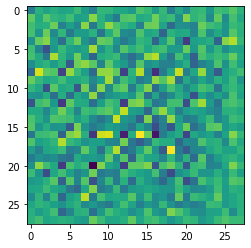

In [16]:
class Generator(nn.Module):
    def __init__(self, noise_dim: int, width: int, height: int):
        super().__init__()
        self.noise_dim = noise_dim

        self.width = width
        self.height = height
        self.projection_layer_output_size = 256 * int(self.width / 4) * int(self.height / 4)

        self.activation = nn.LeakyReLU(0.02)

        # fully-connected layers: noise -> img
        self.fc = nn.Linear(self.noise_dim, self.projection_layer_output_size)
        self.bn = nn.BatchNorm1d(self.projection_layer_output_size)

        # convolutional layers
        self.tc1 = nn.ConvTranspose2d(256, 128, 
                                      kernel_size=5, 
                                      stride=1,
                                      padding=2,
                                      bias=False)
        self.bn1 = nn.BatchNorm2d(128)

        self.tc2 = nn.ConvTranspose2d(128, 64, 
                                      kernel_size=5, 
                                      stride=2, 
                                      padding=2,
                                      bias=False,
                                      output_padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.tc3 = nn.ConvTranspose2d(64, 1, 
                                      kernel_size=5, 
                                      stride=2, 
                                      padding=2,
                                      bias=False,
                                      output_padding=1)
        self.bn3 = nn.BatchNorm2d(1)
        self.output_activation = nn.Tanh()  # as it suggested in DCGAN paper

    def forward(self, x_noise):
        x = self.activation(self.bn(self.fc(x_noise)))  # shape = [-1, 7*7*256]
        x = x.view(-1, 256, int(self.width / 4), int(self.height / 4))  # [-1, 256, 7, 7]
        x = self.activation(self.bn1(self.tc1(x)))  # [-1, 128, 7, 7]
        x = self.activation(self.bn2(self.tc2(x)))  # [-1, 64, 14, 14]
        x = self.output_activation(self.bn3(self.tc3(x)))  # shape = [-1, 1, 28, 28]
        return x

sample_G = Generator(10, 28, 28).to(device)
sample_noise_generator = NoiseGenerator(10, device)
plt.imshow(get_sample_image(sample_G, 1, sample_noise_generator))

In [28]:
class Discriminator(nn.Module):
    def __init__(self, 
                 width: int, 
                 height: int, 
                 in_channels: int,
                 dropout: int = 0.3):
        super().__init__()
        self.width = width
        self.height = height

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
        )

        self.projection_layer_input_size = 128 * int(self.width / 4) * int(self.height / 4)
        self.projection_layer = nn.Linear(self.projection_layer_input_size, 1)
        
    def forward(self, x):
        out = self.conv_block1(x)  # [-1, 64, 14, 14]
        out = self.conv_block2(out)  # [-1, 128, 7, 7]
        out = out.view(-1, self.projection_layer_input_size)
        return self.projection_layer(out)

sample_D = Discriminator(28, 28, 1, 0.3).to(device)
sample_D(sample_G(sample_noise_generator.generate(2)))

tensor([[-0.4758],
        [-0.3895]], device='cuda:0', grad_fn=<AddmmBackward>)

In [0]:
width = 28
height = 28

def init_models(device, noise_dim, width, height):
    G = Generator(noise_dim, width, height).to(device)
    D = Discriminator(width, height, 1).to(device)
    ng = NoiseGenerator(noise_dim, device)
    return G, D, ng

In [0]:
true_labels = torch.ones(batch_size, 1).to(device)
fake_labels = torch.zeros(batch_size, 1).to(device)

criterion = nn.BCEWithLogitsLoss()

def get_discriminator_loss(predicted_real_labels, predicted_fake_labels):
    real_loss = criterion(predicted_real_labels, true_labels)
    fake_loss = criterion(predicted_fake_labels, fake_labels)
    return fake_loss + real_loss

def get_generator_loss(predicted_fake_labels):
    return criterion(predicted_fake_labels, true_labels)

def init_optimizers(D, G, **params):
    d_opt = optim.Adam(D.parameters(), **params)
    g_opt = optim.Adam(G.parameters(), **params)
    return d_opt, g_opt

In [0]:
G, D, ng = init_models(device, 100, 28, 28)
D_opt, G_opt = init_optimizers(D, G, lr=2e-5, betas=(0.5, 0.999))

n_critic = 1
epochs = 25

G_losses = []
D_losses = []


for epoch in range(epochs):
    for step, (imgs, labels) in enumerate(train_dataloader, 0):
        noise = ng.generate(batch_size)
        fake_imgs = G(noise)
        predicted_fake_labels = D(fake_imgs)

        imgs = imgs.to(device)
        predicted_true_labels = D(imgs)
        
        discriminator_loss = get_discriminator_loss(predicted_true_labels, 
                                                    predicted_fake_labels)
        D.zero_grad()
        discriminator_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            predicted_fake_labels = D(G(noise))
            g_loss = get_generator_loss(predicted_fake_labels)

            G.zero_grad()
            g_loss.backward()
            G_opt.step()
        
        if step % 50 == 0:
            D_losses.append(discriminator_loss.item())
            G_losses.append(g_loss.item())

        if step % 400 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(
                epoch, epochs, step, discriminator_loss.item(), g_loss.item()))
            
            G.eval()
            img = get_sample_image(G, 8, ng)

            dirname = 'samples'
            if not os.path.exists(dirname): os.makedirs(dirname)
            plt.imsave('{}/{}_{}_{}.jpg'.format(dirname, "Vanilla-GAN", 
                                                str(epoch).zfill(2), str(step).zfill(4)
                                                ), img, cmap='gray')

            G.train()

Epoch: 0/25, Step: 0, D Loss: 1.4589450359344482, G Loss: 0.8364604711532593
Epoch: 0/25, Step: 400, D Loss: 0.3713167905807495, G Loss: 2.1253504753112793
Epoch: 0/25, Step: 800, D Loss: 0.09687426686286926, G Loss: 3.3033719062805176
Epoch: 1/25, Step: 0, D Loss: 0.1224207729101181, G Loss: 2.9440407752990723


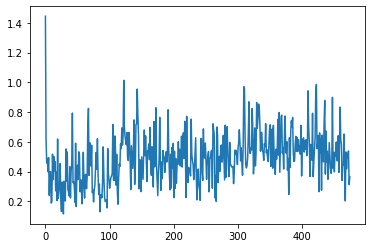

In [26]:
plt.plot(D_losses)

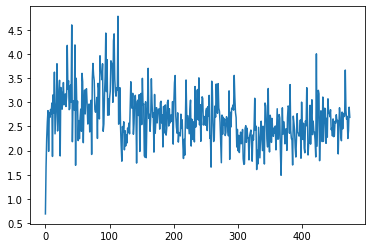

In [27]:
plt.plot(G_losses)